In [2]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap

import IPython.display as display
from matplotlib import animation

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params, 
                # 'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
            }
        
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 28*28, 512, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Dense(neuron_params_norm, 512, 512, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Affine(neuron_params, 512, 10, weight_norm=True, weight_scale=2),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)

        return x

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        simulation = h.create_group('simulation')
        simulation['Ts'] = 1
        simulation['tSample'] = self.time_steps        
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))


In [3]:

trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Dataset and dataLoader instances.
training_set = datasets.MNIST(
        root='data/',
        train=True,
        transform=transforms.Compose([
            transforms.RandomAffine(
                degrees=10, 
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                shear=5,
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]),
        download=True,
    )

testing_set = datasets.MNIST(
        root='data/',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]),
    )

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()



In [4]:

epochs = 100
for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        loss = F.cross_entropy(rate, label.to(device))
        prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()
        # loss = F.mse_loss(rate, F.one_hot(label.to(device), 10).float())

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

            loss = F.cross_entropy(rate, label.to(device))
            prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_accuracy:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()
            
    stats.update()
    stats.save(trained_folder + '/')


[Epoch  0/100] Train 

Input,Output
,
,
,
,
,


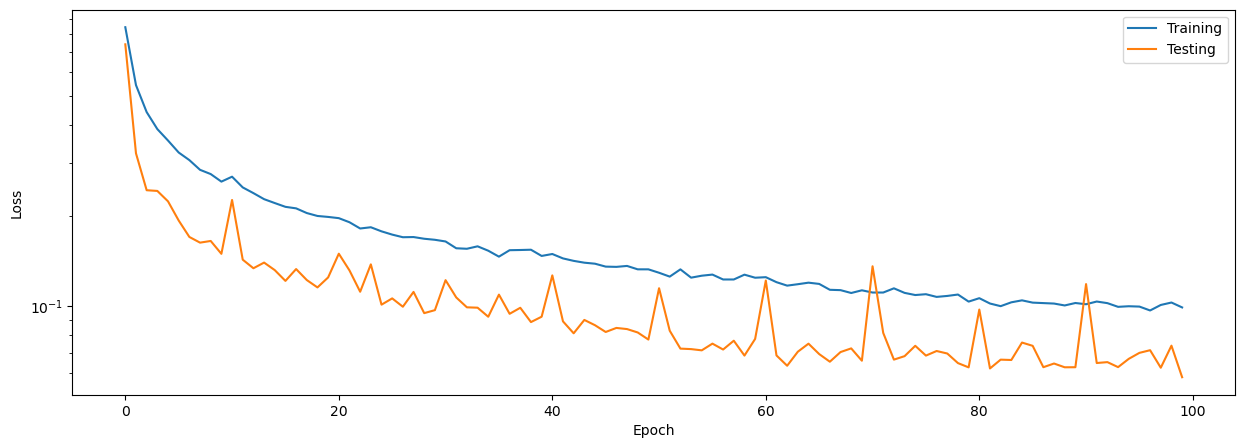

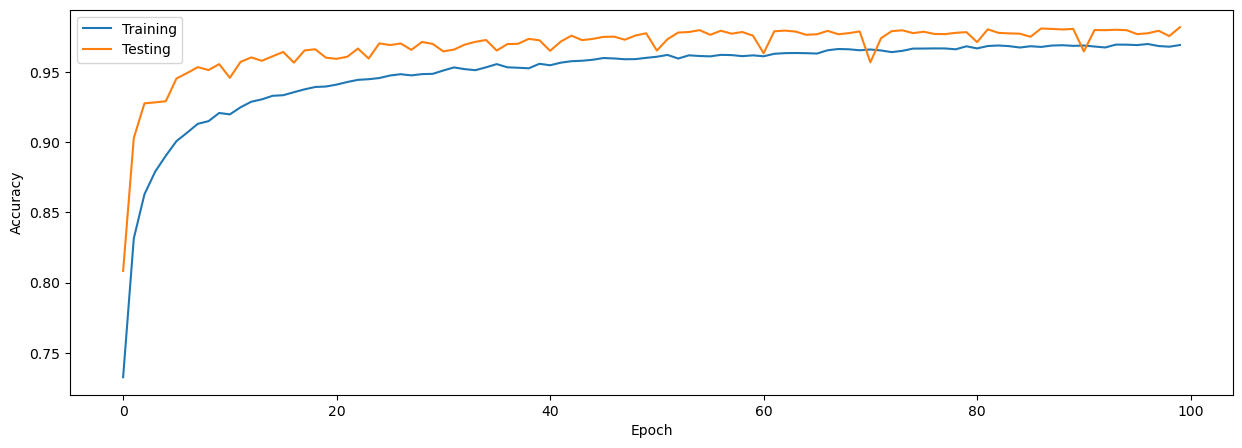

In [5]:

stats.plot(figsize=(15, 5))

output = net(input.to(device), mode=scheduler.mode(100, 0, False))
for i in range(5):
    img = (2*input[i].reshape(28, 28).cpu().data.numpy()-1) * 255
    Image.fromarray(img).convert('RGB').save(f'gifs/inp{i}.png')
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    out_anim = out_event.anim(plt.figure(figsize=(10, 3.5)), frame_rate=2400)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)

img_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 150px;"/> </td>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += img_td(f'gifs/inp{i}.png')
    html += img_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)
